C:\Users\Monish Kiran\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.0444 - val_loss: 0.0116
Epoch 2/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0117 - val_loss: 0.0113
Epoch 3/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 13s 72ms/step - loss: 0.0117 - val_loss: 0.0115
Epoch 4/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - loss: 0.0118 - val_loss: 0.0109
Epoch 5/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.0108 - val_loss: 0.0121
Epoch 6/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0116 - val_loss: 0.0108
Epoch 7/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0106 - val_loss: 0.0108
Epoch 8/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0105 - val_loss: 0.0106
Epoch 9/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0105 - val_loss: 0.0108
Epoch 10/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0108 - val_loss: 0.0105
Epoch 11/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0105 - val_loss: 0.0105
Epoch 12/20
143/143 ━━━━━━━━━━━━━━━━━━━━

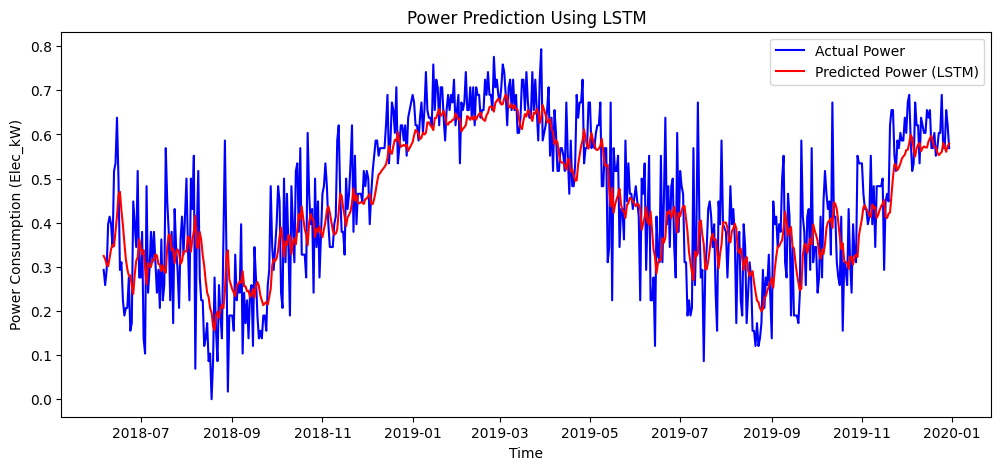

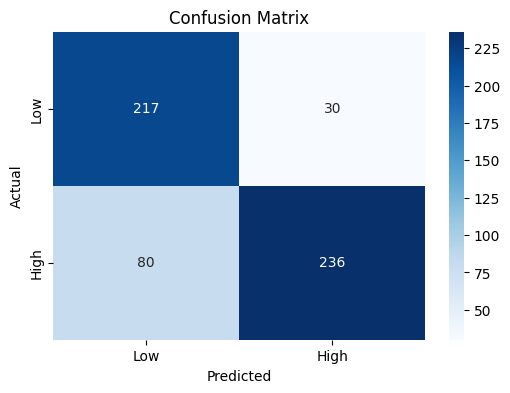

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, mean_absolute_error
import tkinter as tk
from tkinter import messagebox
from datetime import datetime, timedelta

# Load and preprocess dataset
df = pd.read_csv("processed_weather.csv", parse_dates=["Date"], index_col="Date")

# Scale Data
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df[["Elec_kW"]])  # Only scale Elec_kW

# Train-Test Split (80-20)
split = int(len(df) * 0.8)
train_data, test_data = df_scaled[:split], df_scaled[split:]

# Prepare Data for LSTM
def create_sequences(data, seq_length=10):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i : i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 10
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

# Reshape for LSTM (samples, timesteps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Build LSTM Model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

model.compile(optimizer="adam", loss="mean_squared_error")
model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test))

# Predict
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae:.4f}")

# Inverse Transform Predictions
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_actual = scaler.inverse_transform(y_pred)

# Apply smoothing (rolling mean)
window_size = 5
y_test_smooth = pd.Series(y_test_actual.flatten()).rolling(window=window_size, min_periods=1).mean()
y_pred_smooth = pd.Series(y_pred_actual.flatten()).rolling(window=window_size, min_periods=1).mean()

# Convert to Classification Task (High vs Low Power Usage)
threshold = np.median(y_train)  # Using median as threshold
y_test_class = (y_test_actual.flatten() >= threshold).astype(int)  # 1 = High, 0 = Low
y_pred_class = (y_pred_actual.flatten() >= threshold).astype(int)

# Compute Classification Metrics
accuracy = accuracy_score(y_test_class, y_pred_class)
precision = precision_score(y_test_class, y_pred_class)
recall = recall_score(y_test_class, y_pred_class)
f1 = f1_score(y_test_class, y_pred_class)

# Print Metrics
print(f" Accuracy: {accuracy:.4f}")
print(f" Precision: {precision:.4f}")
print(f" Recall: {recall:.4f}")
print(f" F1 Score: {f1:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_class, y_pred_class)

plt.figure(figsize=(12, 5))
plt.plot(df.index[-len(y_test):], y_test, label="Actual Power", color='blue')
plt.plot(df.index[-len(y_test):], y_pred, label="Predicted Power (LSTM)", color='red')
plt.xlabel("Time")
plt.ylabel("Power Consumption (Elec_kW)")
plt.title("Power Prediction Using LSTM")
plt.legend()

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=["Low", "High"], yticklabels=["Low", "High"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# GUI for Future Prediction
def predict_future():
    try:
        input_date = entry.get()
        future_date = datetime.strptime(input_date, "%Y-%m-%d")

        # Define prediction range (next 30 days max)
        last_date = df.index.max()
        max_future_date = last_date + timedelta(days=180)

        if future_date > max_future_date or future_date <= last_date:
            messagebox.showerror("Error", f"Enter a date between {last_date + timedelta(days=1)} and {max_future_date}.")
            return

        # Generate Input Sequence for Prediction
        last_sequence = df_scaled[-seq_length:].reshape(1, seq_length, 1)
        future_pred_scaled = model.predict(last_sequence)
        future_pred = scaler.inverse_transform(future_pred_scaled)[0][0]

        # Convert Prediction to Classification
        future_class = "High" if future_pred >= threshold else "Low"

        messagebox.showinfo("Prediction", f"Predicted Elec_kW for {input_date}: {future_pred:.2f} kW\nCategory: {future_class} Power Usage")

    except Exception as e:
        messagebox.showerror("Error", f"Invalid input! Enter date in YYYY-MM-DD format.\n{e}")

# Create GUI
root = tk.Tk()
root.title("Electricity Prediction")

tk.Label(root, text="Enter a future date (YYYY-MM-DD):").pack(pady=5)
entry = tk.Entry(root)
entry.pack(pady=5)

btn = tk.Button(root, text="Predict", command=predict_future)
btn.pack(pady=10)

root.mainloop()

model.save("lstm_model.h5")

Mean Absolute Error: 6.5894
Accuracy: 0.7958
Precision: 0.7897
Recall: 0.7012
F1-score: 0.7429


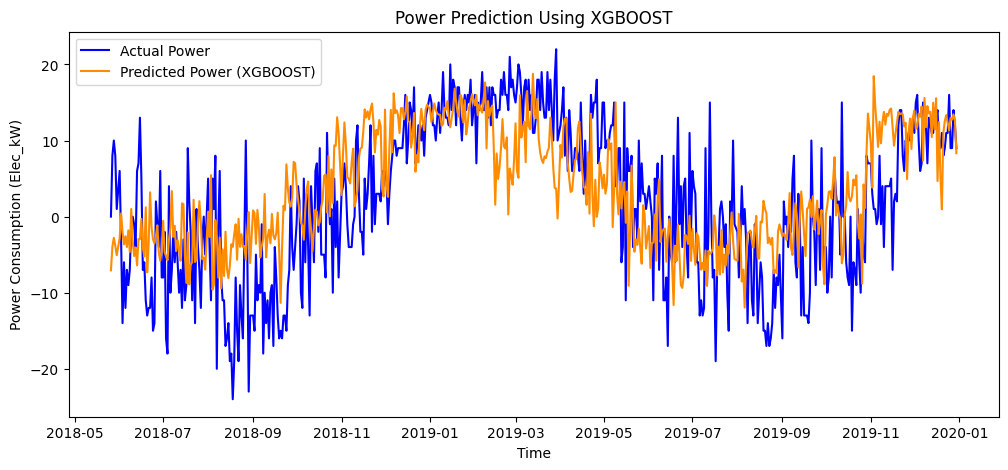

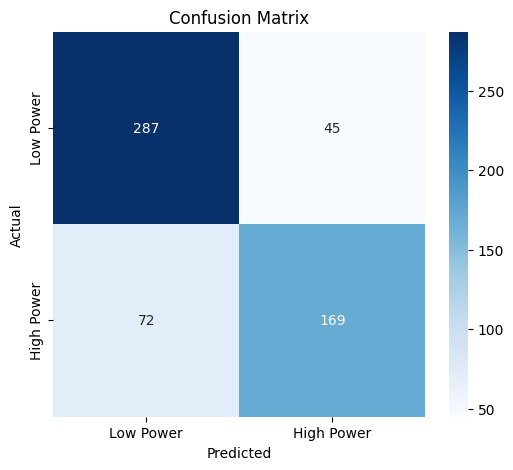

['xgb_model.pkl']

In [2]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import tkinter as tk
from tkinter import messagebox
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

# Load Dataset
df = pd.read_csv("processed_weather.csv")

# Convert 'Date' column to datetime & set it as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Define Features and Target
target_col = "Elec_kW"
features = [col for col in df.columns if col != target_col]

scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df[["Elec_kW"]])

# Train-Test Split (80% Train, 20% Test)
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

X_train, y_train = train[features], train[target_col]
X_test, y_test = test[features], test[target_col]

# Train XGBoost Model
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=200, learning_rate=0.05)
model.fit(X_train, y_train)

# Make Predictions
y_pred = model.predict(X_test)

# Evaluate Model
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae:.4f}")

# Convert Regression to Classification
threshold = y_train.median()  # Median power usage as threshold
y_test_class = (y_test >= threshold).astype(int)
y_pred_class = (y_pred >= threshold).astype(int)



# Compute Classification Metrics
accuracy = accuracy_score(y_test_class, y_pred_class)
precision = precision_score(y_test_class, y_pred_class, zero_division=1)
recall = recall_score(y_test_class, y_pred_class, zero_division=1)
f1 = f1_score(y_test_class, y_pred_class)
conf_matrix = confusion_matrix(y_test_class, y_pred_class)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")


plt.figure(figsize=(12, 5))
plt.plot(df.index[-len(y_test):], y_test, label="Actual Power", color='blue')
plt.plot(df.index[-len(y_test):], y_pred, label="Predicted Power (XGBOOST)", color='darkorange')
plt.xlabel("Time")
plt.ylabel("Power Consumption (Elec_kW)")
plt.title("Power Prediction Using XGBOOST")
plt.legend()

# Display Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Low Power", "High Power"], yticklabels=["Low Power", "High Power"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# GUI for Future Prediction
def predict_future():
    try:
        input_date = entry.get()
        future_date = datetime.strptime(input_date, "%Y-%m-%d")

        # Define prediction range (next 180 days max)
        last_date = df.index.max()
        max_future_date = last_date + timedelta(days=180)

        if future_date > max_future_date or future_date <= last_date:
            messagebox.showerror("Error", f"Enter a date between {last_date + timedelta(days=1)} and {max_future_date}.")
            return

        # Generate Input Sequence for Prediction
        future_df = pd.DataFrame(columns=features)
        for col in features:
            future_df[col] = [df[col].mean()]  # Using mean values for prediction

        future_pred = model.predict(future_df)[0]

        # Convert Prediction to Classification
        future_class = "High" if future_pred >= threshold else "Low"

        messagebox.showinfo("Prediction", f"Predicted Elec_kW for {input_date}: {future_pred:.2f} kW\nCategory: {future_class} Power Usage")

    except Exception as e:
        messagebox.showerror("Error", f"Invalid input! Enter date in YYYY-MM-DD format.\n{e}")

# Create GUI
root = tk.Tk()
root.title("Electricity Prediction")

tk.Label(root, text="Enter a future date (YYYY-MM-DD):").pack(pady=5)
entry = tk.Entry(root)
entry.pack(pady=5)

btn = tk.Button(root, text="Predict", command=predict_future)
btn.pack(pady=10)

root.mainloop()

import joblib
joblib.dump(model, "xgb_model.pkl")

Epoch 1/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - loss: 0.0500 - mae: 0.1702 - val_loss: 0.0183 - val_mae: 0.1075
Epoch 2/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0126 - mae: 0.0891 - val_loss: 0.0169 - val_mae: 0.1030
Epoch 3/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0115 - mae: 0.0845 - val_loss: 0.0170 - val_mae: 0.1052
Epoch 4/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0114 - mae: 0.0837 - val_loss: 0.0156 - val_mae: 0.0993
Epoch 5/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0113 - mae: 0.0835 - val_loss: 0.0157 - val_mae: 0.1000
Epoch 6/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.0119 - mae: 0.0846 - val_loss: 0.0164 - val_mae: 0.1034
Epoch 7/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0110 - mae: 0.0827 - val_loss: 0.0159 - val_mae: 0.1005
Epoch 8/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0104 - mae: 0.0788 - val_loss: 0.0156 - val_mae: 0.1000
Epoch 9/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/

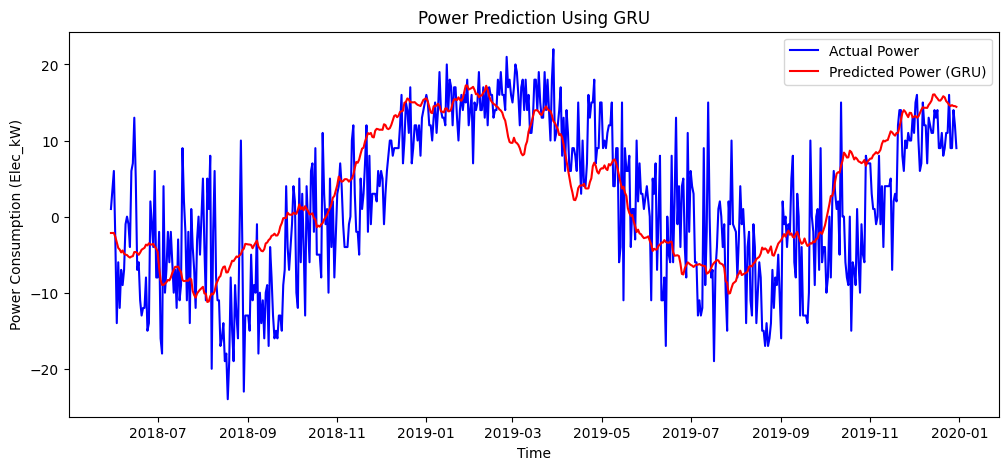

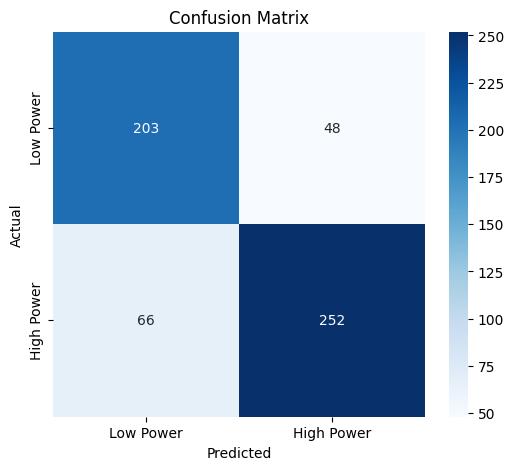

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tkinter as tk
from tkinter import messagebox
from datetime import datetime, timedelta
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, mean_absolute_error
from tensorflow import keras

# Load dataset
file_path = "processed_weather.csv"  # Update with correct path
df = pd.read_csv(file_path, parse_dates=["Date"], index_col="Date")

# Selecting features and target variable
features = ["temp", "humidity", "wind", 'barometer', 'Weather_Label']  # Update with actual column names
target_col = "Elec_kW"

df = df.dropna(subset=[target_col] + features)

# Normalize data
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

# Function to create sequences
def create_sequences(data, target_col, feature_cols, seq_length=24):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[feature_cols].iloc[i:i+seq_length].values)
        y.append(data[target_col].iloc[i+seq_length])
    return np.array(X), np.array(y)

# Define sequence length
seq_length = 24
X, y = create_sequences(df_scaled, target_col, features, seq_length)

# Train-test split
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build GRU model
model = Sequential([
    GRU(64, activation="relu", return_sequences=True, input_shape=(seq_length, len(features))),
    GRU(32, activation="relu"),
    Dense(1)
])

model.compile(optimizer="adam", loss="mse", metrics=["mae"])

# Train model
history = model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test), verbose=1)

# Make Predictions
y_pred = model.predict(X_test)

y_test_inv = scaler.inverse_transform(np.c_[np.zeros((len(y_test), len(features))), y_test])[:, -1]
y_pred_inv = scaler.inverse_transform(np.c_[np.zeros((len(y_pred), len(features))), y_pred.squeeze()])[:, -1]


mae = mean_absolute_error(y_test_inv, y_pred_inv)
print(f"MAE: {mae:.4f}")

# Compute Classification Metrics
threshold = np.median(y_train)
y_test_class = (y_test_inv >= threshold).astype(int)
y_pred_class = (y_pred_inv >= threshold).astype(int)

accuracy = accuracy_score(y_test_class, y_pred_class)
precision = precision_score(y_test_class, y_pred_class, zero_division=1)
recall = recall_score(y_test_class, y_pred_class, zero_division=1)
f1 = f1_score(y_test_class, y_pred_class)
conf_matrix = confusion_matrix(y_test_class, y_pred_class)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# Plot Actual vs Predicted
plt.figure(figsize=(12, 5))
plt.plot(df.index[-len(y_test):], y_test_inv, label="Actual Power", color='blue')
plt.plot(df.index[-len(y_test):], y_pred_inv, label="Predicted Power (GRU)", color='red')
plt.xlabel("Time")
plt.ylabel("Power Consumption (Elec_kW)")
plt.title("Power Prediction Using GRU")
plt.legend()


plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Low Power", "High Power"], yticklabels=["Low Power", "High Power"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

plt.show()

# GUI for Future Prediction
def predict_future():
    try:
        input_date = entry.get()
        future_date = datetime.strptime(input_date, "%Y-%m-%d")

        last_date = df.index.max()
        max_future_date = last_date + timedelta(days=180)

        if future_date > max_future_date or future_date <= last_date:
            messagebox.showerror("Error", f"Enter a date between {last_date + timedelta(days=1)} and {max_future_date}.")
            return

        last_sequence = X_test[-1].reshape(1, seq_length, len(features))
        future_pred_scaled = model.predict(last_sequence)
        future_pred = scaler.inverse_transform(np.c_[np.zeros((1, len(features))), future_pred_scaled])[0][-1]

        future_class = "High" if future_pred >= threshold else "Low"

        messagebox.showinfo("Prediction", f"Predicted Elec_kW for {input_date}: {future_pred:.2f} kW\nCategory: {future_class} Power Usage")
    except Exception as e:
        messagebox.showerror("Error", f"Invalid input! Enter date in YYYY-MM-DD format.\n{e}")

# Create GUI
root = tk.Tk()
root.title("Electricity Prediction (GRU)")

tk.Label(root, text="Enter a future date (YYYY-MM-DD):").pack(pady=5)
entry = tk.Entry(root)
entry.pack(pady=5)

btn = tk.Button(root, text="Predict", command=predict_future)
btn.pack(pady=10)

root.mainloop()

model.save("gru_model.h5")
# Explicitly define the loss function
custom_objects = {"mse": keras.losses.MeanSquaredError()}

# Load the model
gru_model = keras.models.load_model("gru_model.h5", custom_objects=custom_objects)